# 5. Segregation Indexes
Following the Bojanowski & Corten Paper _Measuring Segregation in Social Networks_ 2014, We calculate some segregation indexes for our graphs along the time. First, we import the data and libraries ised for the creation of the functions in the Prerequiste section. Then We calculate The Freeman Segregation Index and the Spectral Segregatoin Index in The next Sections. This Notebook is divided en the following sections.

1. Prerequisites
2. Freeman Segregation
	- Basic Freeman Segregation
	- Global Freeman Segregation Index (for K groups)
	- Freeman Segregation Index for an specific group
	- Freeman Segregation Index for an specific group (Taking in account Weights)
3. Assortativity
4. Results
4.1. 3 Day Rolling Window
4. Conclusion


## 1. Prerequistes

In [2]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd

# Graph Managment
import graph_tool.all as gt
import utils.subutils.Functions as Fun
import utils.Segregation as Seg

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Miscellaneous
from glob import glob
from tqdm import tqdm
from datetime import datetime, timedelta

# Reload Utils
import importlib
importlib.reload(Seg)
importlib.reload(Fun)

<module 'utils.subutils.Functions' from '/mnt/disk2/fcastrillon/Analysis-of-Tweets-During-the-2021-Social-Unrest/Code/utils/subutils/Functions.py'>

For the calculation of the segregation Indexes, we define some notation based on (Bojanowski & Corten 2014).

We define a Graph with

$$\mathbb{N}= \{1, \dots, i, \dots, N\}$$

and then, define the set

$$\mathbb{G} = \{G_1, G_2,\dots, G_k\}$$

as the set of $K$ groups in which every $G_g$ is a subset of $\mathbb{N}$ that contains all the nodes that belong to group $g$. define $\eta_{k}$ = $|G_k|$ as the amount of nodes from group $G_k$

Now we define the type vector as 

$$\textbf{t} = [t_1,\dots, t_i, \dots, t_N]$$

where $t_i \in \{1,\dots,K\}$. This vector matches every node with its corresponding group. Using this notation. We can define a type indicator vector for each group $k$ as follows:  

$$\textbf{v}_k = [v_1, \dots, v_i, \dots, v_N]$$ 

where $v_i \in \{0,1\}$. This vector has one entry for every node and the node location will have a 1 if that node corresponds to the group $G_k$. Formally:

$$ v_i = \begin{cases} 1 &\text{ if }t_i = k \\ 0 &\text{ if }t_i \neq k \end{cases} $$

Now we define the Types Matrix $T_{N\times K}$ as a matrix that contains the information of each node and wich group it represents. For Every column of the matrix corresponds to a $\textbf{v}_k$ _types indicator vector_.

In the context of this Research, we will use a Directed Weighted Graph. Our nodes are X (formmerly Twitter) in which the user $i$ is related to the user $j$ if $i$ Retweeted a Tweet without comments of $j$. In this sense. Formarly we discribe the relationship $R$ over $\mathbb{N}\times \mathbb{N}$ that implies our square Adjcency Matrix $X = [X_{ij}]_{\mathbb{N}\times \mathbb{N}}$

For the segregation calculations will will consider the graph as weighted or un weight. In case of takin in account the weights of each edge, eh entries of the Adjacency Matrix will be defined as follows:

$$x_{ij} = \dfrac{\text{\# Tweets from }j\text{ that }i\text{ Retweeted without comments}}{\text{\# of Retweets without comments from }i}$$

Taking in account the unweighted graph, we will define our Simple Adjacency Matrix as:

$$ x_{ij} = \begin{cases} 1 & \text{if } i\text{ Retweeted }j \\ 0 & \text{In other case} \end{cases} $$

Finally, we define the _Mixing Matrix_ ($M_{ghy}$) where $g$ and $h$ are two generic groups and $y$ indexes two types of layers. The first layer _Mixing Matrix_ is the _Contact layer_, defined as follows: (Where we use the weighted or un weighted adjcancecy matrix):

$$M_{gh1} = \sum_{i\in G_g}\sum_{j\in G_h} x_{ij}$$

For the **unweighted** case, we can define the _No Contact Layer_ as follows:

$$M_{gh0} = \sum_{i\in G_g}\sum_{j\in G_h} (1-x_{ij})$$

Finally, in this matrix $M_{gh1}$ shows the amount of attention that group $h$ gets from group $g$

For easyness, we define the follow notation:

- $M_{g+1} = \sum_{g=1}^K M_{gh1}$ Sum across a row

- $M_{+h1} = \sum_{h=1}^K M_{gh1}$ Sum across a column

- $M_{++1} = \sum_{g=1}^K \sum_{h=1}^K M_{gh1}$ Sum of all the Layer

In [3]:
# Indexes
date_range = pd.date_range(start='2021-04-28', end='2021-06-27', freq='D')
categories = ['Izquierda', 'Derecha', 'Centro', 'No Retweets']
multi_index = pd.MultiIndex.from_product([date_range, categories], names=['Date', 'Political Label'])

# DataFrames with statistics
global_segregation = pd.DataFrame(index=date_range).sort_index()
group_segregation = pd.DataFrame(index=multi_index).sort_index()

# Load graphs
files = glob('/mnt/disk2/Data/3_Day_Graphs/*.graphml')

---
## 2. Freman Segregation

### Basic Freeman Segregation

The basic segregation index proposed by Freeman (1998) tries to see how is the proportion of ties between two different groups against the ties if they were made randomly. This Basic Index is calculated for undirected and unweighted graphs. It is the first approch for segregation for this family of indexes. We define the $\eta_1$ as the amount of nodes belonng to group $G_1$ and $\eta_2$ belonging to group $G_2$. Recalling our past notation, in the contact Layer of the mixing matrix the number of between group ties will be the entry $M_{121}$. We can divide this numero over all the amount of edges (Note that the nuber of edges in the graph is equal to the sum of all the contact layer $M_{++1}$). This is how we get the proportion of between ties

$$p = \frac{M_{121}}{M_{++1}}$$

Now, we calculate the expected value of $p$ Note that the probability of taking a tie between the node of a one group and a node with the other group will be conjunct probabilty of taking a dyad with a node beloging to $G_1$ out of the total of dyads and doing the same for a dyad with a node from group $G_2$. (Note that the number of dyads corresponds to _N choose 2_)

$$\pi = \frac{\eta_1}{\frac{N(N-1)}{2}} \times \frac{\eta_2}{\frac{N(N-1)}{2}} = \frac{2\eta_1 \eta_2}{N(N-1)}$$

Finally Freeman Segregation Index is defined as:

$$S_{Freeman} = 1- \frac{p}{\pi}$$

In [4]:
# Storage in DataFrame
for file in tqdm(files):
    for pol in categories:
        g = gt.load_graph(file)
        graph_name = file.split('/')[-1].split('.')[0].split('_')[-1]
        seg = Seg.Freeman_Two_Groups(g,types = pol)
        group_segregation.loc[(graph_name, pol), 'Freeman Two Groups'] = seg

100%|██████████| 61/61 [13:25<00:00, 13.21s/it]


---
### Global Freeman Segregation Index (for K groups)

For the Freeman Segregation Index, We will use the formula from (Bojanowski & Corten 2014) for the in which the generalize this index for $K$ groups. The index is define as Follows.

Let $p$ be equal to the proportion of _between_ group ties in the graph. This corresponds to the upper triangle of the $M$ Matrix without counting the diagonal (This diagonal contains the information of the _within_ group ties).

$$p = \frac{\sum_{g,h:g\neq h}M_{gh1}}{\sum_{g=1}^K\sum_{h=1}^K M_{gh1}}$$

Now, we define the expected proportion of between-group ties in a random graph. In the generalize case of $K$ groups. this looks like this

$$\pi = \frac{\left( \sum_{k=1}^K \eta_k\right)^2 - \sum_{k=1}^K \eta_k^2}{N(N-1)}$$

Finally, Freeman Segregation Index is defined as:

$$S_{Freeman} = 1 -\frac{p}{\pi} = 1- \frac{pN(N-1)}{\left( \sum_{k=1}^K \eta_k\right)^2 - \sum_{k=1}^K \eta_k^2}$$

This Index takes into account the case **unweighted case**

In [6]:
# Storage in DataFrame
for file in tqdm(files):
    g = gt.load_graph(file)
    graph_name = file.split('/')[-1].split('.')[0].split('_')[-1]
    seg = Seg.Freeman_Global_No_Weight(g,types = 'Political Label')
    global_segregation.loc[(graph_name), 'Freeman No Weighted'] = seg

100%|██████████| 61/61 [03:24<00:00,  3.35s/it]


---
### Freeman Segregation Index for an specific group

The Freeman Segregation Index is originally computed for the segregation between two groups. This function will compute the index between one group and all the other ones using _Basic Freeman Segregatioon Index_ Formula. This will give a measure of how segregated is one group over all the others. For this case, our contact layer will only consider two groups, the group $g$ for which one would calculate the index and the group $-g$ wich are all the other nodes that do not belong to $g$. Recall our _Contact Matrix_ that looks like this:

$$
M_{gh1} = 
\begin{bmatrix}
    M_{1,1,1} & M_{1,2,1} & \dots & M_{1,k,1} \\
    M_{2,1,1} & M_{2,2,1} & \dots & M_{2,k,1} \\
    \vdots & \vdots & \ddots & \vdots \\
    M_{k,1,1} & M_{k,2,1} & \dots & M_{k,k,1} \\
\end{bmatrix}
$$

For our calculation, we will  have another _Contact Catrix_ called, "Me Vs Ohers" and denoted $\hat{M}$. This matrix will be a $2\times 2$. This will be similar as the the original _Contact Matrix_ but with only two groups, $g$ and $-g$. This matrix is defined as follows:

$$
M^* = 
\begin{bmatrix}
    M*_{gg} & M*_{g-g} \\
    M*_{-gg} & M*_{-g-g} \\
\end{bmatrix}
$$

Where:
- $M^*_{g-g} = M_{gg1}$
- $M^*_{g-g} = \sum_{g = 1}^k M_{gh1} - M_{gg1}$
- $M^*_{-gg} = \sum_{h = 1}^k M_{gh1} - M_{gg1}$
- $M^*_{-g-g} = \sum \sum \hat{M}_{gh}$

For the calculation of the $M*_{-g-g1}$ we substract from the original _Contact Matrix_ the index rows and columns for the group $g$ (Will be denoted as $\hat{M}$). This will be the contact matrix if this group hadn't existed. Thanks to this matrix, we can compute all the between ties from all nodes that aren't in $g$. This will be the sum of all the values in the matrix. Formally,
$$
\hat{M} = 
    \begin{bmatrix}
    a_{1,1} & \dots & a_{1,g-1} & a_{1,g+1} & \dots & a_{1,k} \\
    a_{2,1} & \dots & a_{2,g-1} & a_{2,g+1} & \dots & a_{2,k} \\
    \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
    a_{g-1,1} & \dots & a_{g-1,g-1} & a_{g-1,g+1} & \dots & a_{g-1,k} \\
    a_{g+1,1} & \dots & a_{g+1,g-1} & a_{g+1,g+1} & \dots & a_{g+1,k} \\
    \vdots & \ddots & \vdots & \vdots & \ddots & \vdots \\
    a_{k,1} & \dots & a_{k,g-1} & a_{k,g+1} & \dots & a_{k,k} \\
\end{bmatrix}
$$

Now, for the Freeman Formula we compute both $P$ and $\pi$ and calculate $1-\frac{P}{\pi}$

$$P = \frac{M^*_{12}}{M^*_{++}}$$

$$\pi = \frac{2|G_g|*|G_{-g}|}{N(N-1)}$$

$$S_{Freeman}^g = 1- \frac{N(N-1)M^*_{12}}{2M^*_{++}|G_g||G_{-g}|}$$

In [8]:
# Storage in DataFrame
for file in tqdm(files):
    for pol in categories:
        g = gt.load_graph(file)
        graph_name = file.split('/')[-1].split('.')[0].split('_')[-1]
        seg = Seg.Freeman_Groups_No_Weight(g,types = 'Political Label', group = pol)
        group_segregation.loc[(graph_name, pol), 'Freeman No Weighted'] = seg

100%|██████████| 61/61 [13:51<00:00, 13.64s/it]


---
### Freeman Segregation Index for an specific group (Taking in account Weights)
The function described below is intended to be use with the weighted graph. We will use precious notation for this formula.

$$P = \frac{M^*_{12}}{M^*_{12} + M^*_{11}}$$

$$\pi = \frac{|G_g|}{N}$$

In this case, the Freeman Segregation Index for a weighted and directed graph is equal to:

$$S_{Freeman}^g = 1-\frac{P}{\pi}$$

In [11]:
# Storage in DataFrame
for file in tqdm(files):
    for pol in categories:
        g = gt.load_graph(file)
        graph_name = file.split('/')[-1].split('.')[0].split('_')[-1]
        seg = Seg.Freeman_Groups_Weight(g, weights='Normal Weights',group = pol, types = 'Political Label')
        group_segregation.loc[(graph_name, pol), 'Freeman Weighted'] = seg

100%|██████████| 61/61 [13:57<00:00, 13.73s/it]


---
## 3. Assorativity

- **Assortativity:** is a preference for a network's nodes to attach to others that are similar in some way. Though the specific measure of similarity may vary, network theorists often examine assortativity in terms of a node's degree.

    The **assortativity coefficient** is the Pearson correlation coefficient of degree between pairs of linked nodes. Positive values of `r` indicate a correlation between nodes of similar degree, while negative values indicate relationships between nodes of different degree. In general, `r` lies between `−1` and `1`. When `r = 1`, the network is said to have perfect assortative mixing patterns, when `r = 0` the network is non-assortative, while at `r = −1` the network is completely disassortative.

    The *assortativity coefficient* is given by 

    $$
    r = \frac{\sum_{jk}{jk (e_{jk} - q_j q_k)}}{\sigma_{q}^{2}}
    $$

    In this equation:

    - $ \sum_{jk} $ denotes the summation over all degrees $ j $ and $ k $ in the network.
    - $ jk $ represents the product of degrees $ j $ and $ k $.
    - $ e_{jk} $ is the joint probability distribution of the remaining degrees of two connected vertices. In an undirected graph, this is symmetric and must satisfy the sum rules:
        - $ \sum_{jk}{e_{jk}} = 1 $, ensuring that the total probability is 1.
        - $ \sum_{j}{e_{jk}} = q_{k} $, linking it to the distribution of the remaining degree.
    - $ q_j $ and $ q_k $ are the distributions of the remaining degree for vertices of degrees $ j $ and $ k $, respectively. 
    - $ \sigma_{q}^{2} $ is the variance of the distribution of the remaining degree.

    The term $ q_{k} $ represents the distribution of the *remaining degree*, which captures the number of edges leaving a node, excluding the edge that connects the pair in question. This distribution is derived from the degree distribution $ p_{k} $ as follows:

    $$
    q_{k} = \frac{(k+1)p_{k+1}}{\sum_{j \geq 1} j p_j}
    $$

    - Here, $ p_{k} $ is the degree distribution of the network, and $ p_{k+1} $ refers to the probability of a node having $ k+1 $ connections.


- **Categorical Assortativity (assortativity by attribute):** is a measure used to determine how often nodes with a certain categorical attribute, like color or type, connect to other nodes with the same attribute. It is given by:

    $$
    r = \frac{\sum_{ij}{e_{ij} - q_i q_j}}{\sum_{i}{q_i q_i} - \sum_{i}{q_i q_j}}
    $$

    Where:

    - $ e_{ij} $ is the proportion of edges in the network that connect nodes of type $ i $ to nodes of type $ j $.
    - $ q_i $ and $ q_j $ are the proportions of each type of node (type $ i $ and $ j $, respectively) at the ends of a randomly chosen edge.

    In this context:

    - A positive value of $ r $ indicates assortative mixing, where nodes tend to connect to others that are similar.
    - A negative value of $ r $ indicates disassortative mixing, where nodes tend to connect to others that are different.
    - A value of $ r $ close to 0 suggests no particular preference for nodes to connect to others based on the categorical attribute.

In [84]:
# Storage in DataFrame
for file in tqdm(files):
    g = gt.load_graph(file)
    graph_name = file.split('/')[-1].split('.')[0].split('_')[-1]
    for pol in categories:
        # Non weighted
        seg_w = gt.assortativity(g, g.vp[pol])
        group_segregation.loc[(graph_name, pol), 'Non Weighted Assortativity'] = seg_w[0]
        #print(seg_w)
        
        # Weighted
        seg_no_w = gt.assortativity(g, g.vp[pol], eweight=g.ep['Normal Weights'])
        group_segregation.loc[(graph_name, pol), 'Normal Weighted Assortativity'] = seg_no_w[0]
        
        seg_no_w = gt.assortativity(g, g.vp[pol], eweight=g.ep['Number of rts'])
        group_segregation.loc[(graph_name, pol), 'Weighted Assortativity'] = seg_no_w[0]
        
    #Global
    seg = gt.assortativity(g, g.vp['Political Label'], eweight=g.ep['Normal Weights'])
    global_segregation.loc[(graph_name), 'Normal Weighted Assortativity'] = seg[0]
    
    seg = gt.assortativity(g, g.vp['Political Label'], eweight=g.ep['Number of rts'])
    global_segregation.loc[(graph_name), 'Weighted Assortativity'] = seg[0]
    
    seg = gt.assortativity(g, g.vp['Political Label'])
    global_segregation.loc[(graph_name), 'Non Weighted Assortativity'] = seg[0]

100%|██████████| 61/61 [02:30<00:00,  2.47s/it]


---
## Homiphily Index

refers to the tendency of individuals (or nodes in a network) to associate and bond with similar others. The similarity can be based on various attributes such as social characteristics, behaviors, or beliefs. In the context of a network, this implies that nodes are more likely to form connections with other nodes that belong to the same group or share similar attributes. 

Measuring Homophily. We begin with some simple definitions that are important in measuring homophily and also in presenting the model.

Let $ N $ denote the number of type $ i $ individuals in the population, and let $ w_i = \frac{N_i}{N} $ be the relative fraction of type $ i $ in the population, where $ N = \sum_k N_k $.

Let $ s_i $ denote the average number of friendships that agents of type $ i $ have with agents who are of the same type, and let $ d_i $ be the average number of friendships that type $ i $ agents form with agents of types different from $ i $. Let $ t_i = s_i + d_i $ be the average total number of friendships that type $ i $ agents form.

The homophily index $ H_i $ measures the fraction of the ties of individuals of type $ i $ that are with that same type.

**Definition 1** The homophily index $ H_i $ is defined by

$$ H_i = \frac{s_i}{s_i + d_i} $$

The profile $ (s, d) $ exhibits *baseline homophily* for type $ i $ if $ H_i = w_i $.

The profile $ (s, d) $ exhibits *inbreeding homophily* for type $ i $ if $ H_i > w_i $.

Generally, there is a difficulty in simply measuring homophily according to $ H_i $. For example, consider a group that comprises 95% of a population. Suppose that its same-type friendships are 95% of its friendships. Compare this to a group that comprises 5% of a population and has 96% of its friendships being same-type. Although both have the same homophily index, they are very different in terms of how homophilous they are relative to how homophilous they could be. Comparing the homophily index, $ H_i $, to the baseline, $ w_i $, provides some information, but even that does not fully capture the idea of how biased a group is compared to how biased it could potentially be. To take care of this we use the inbreeding homophily index introduced by Coleman [Coleman J. (1958) *Human Organization* 17:28–36] that normalizes the homophily index by the potential extent to which a group could be biased.

**Definition 2** Coleman's inbreeding homophily index of type $i$ is

$$IH_i = \frac{H_i - w_i}{1 - w_i}$$

This index measures the amount of bias with respect to baseline homophily as it relates to the maximum possible bias (the term $ 1 - w_i $). It can be easily checked that we have inbreeding homophily for type $ i $ if and only if $ IH_i > 0 $, and inbreeding heterophily for type $ i $ if and only if $ IH_i < 0 $. The index of inbreeding homophily is 0 if there is pure baseline homophily, and 1 if a group completely inbreeds.

In [77]:
for file in tqdm(files):
    # Get date
    date = file.split('/')[-1].split('.')[0].split('_')[-1]
    g = gt.load_graph(file)

    Homiphily_dict = Seg.homophily_index(graph = g, property_name = "Political Label")
    H = Homiphily_dict ['H_i']
    IH = Homiphily_dict ['IH_i']
    for key in H.keys():
        group_segregation.loc[(date, key), 'Homiphily Index'] = H[key]
        group_segregation.loc[(date, key), 'Inbreeding Homiphily Index'] = IH[key]

100%|██████████| 61/61 [03:55<00:00,  3.87s/it]


## Spectral Segregation Index

Explicación pendiente

In [94]:
group_segregation.head()

Freeman Two Groups  Freeman No Weighted  \
Date       Political Label                                            
2021-04-28 Centro                     0.525626             0.525626   
           Derecha                    0.466362             0.466362   
           Izquierda                  0.446781             0.446781   
           No Retweets                0.494191             0.494191   
2021-04-29 Centro                     0.535258             0.535258   

                            Freeman Weighted  Non Weighted Assortativity  \
Date       Political Label                                                 
2021-04-28 Centro                   0.896314                    0.004970   
           Derecha                  0.758660                    0.004802   
           Izquierda               -0.798112                    0.006748   
           No Retweets              0.905720                    0.001993   
2021-04-29 Centro                   0.897217                    0.003377   

                            Weighted Assortativity  \
Date       Political Label                           
2021-04-28 Centro                         0.737843   
           Derecha                        0.913595   
           Izquierda                      1.145352   
           No Retweets                    0.814524   
2021-04-29 Centro                         0.987659   

                            Normal Weighted Assortativity  Homiphily Index  \
Date       Political Label                                                   
2021-04-28 Centro                                0.021042         0.160421   
           Derecha                               0.025188         0.138817   
           Izquierda                             0.027674         0.569951   
           No Retweets                           0.016908         0.144530   
2021-04-29 Centro                                0.016554         0.177124   

                            Inbreeding Homiphily Index  
Date       Political Label                              
2021-04-28 Centro                             0.064086  
           Derecha                           -0.059852  
           Izquierda                         -0.123789  
           No Retweets                        0.057545  
2021-04-29 Centro                             0.083250

In [85]:
global_segregation.head()

,Freeman No Weighted,Weighted Assortativity,Non Weighted Assortativity,Normal Weighted Assortativity
2021-04-28,-1.136798,0.342178,0.005122,0.023932
2021-04-29,-1.123433,0.974833,0.004359,0.019865
2021-04-30,-1.139248,0.819227,0.005765,0.021263
2021-05-01,-1.149521,2.302583,0.004236,0.023322
2021-05-02,-1.139981,-0.223439,0.004591,0.020636


In [93]:
# Run to save
#group_segregation.to_pickle('/mnt/disk2/Data/Pickle/group_segregation.pkl')
#global_segregation.to_pickle('/mnt/disk2/Data/Pickle/global_segregation.pkl')

In [3]:
group_segregation = pd.read_pickle('/mnt/disk2/Data/Pickle/group_segregation.pkl')
global_segregation = pd.read_pickle('/mnt/disk2/Data/Pickle/global_segregation.pkl')

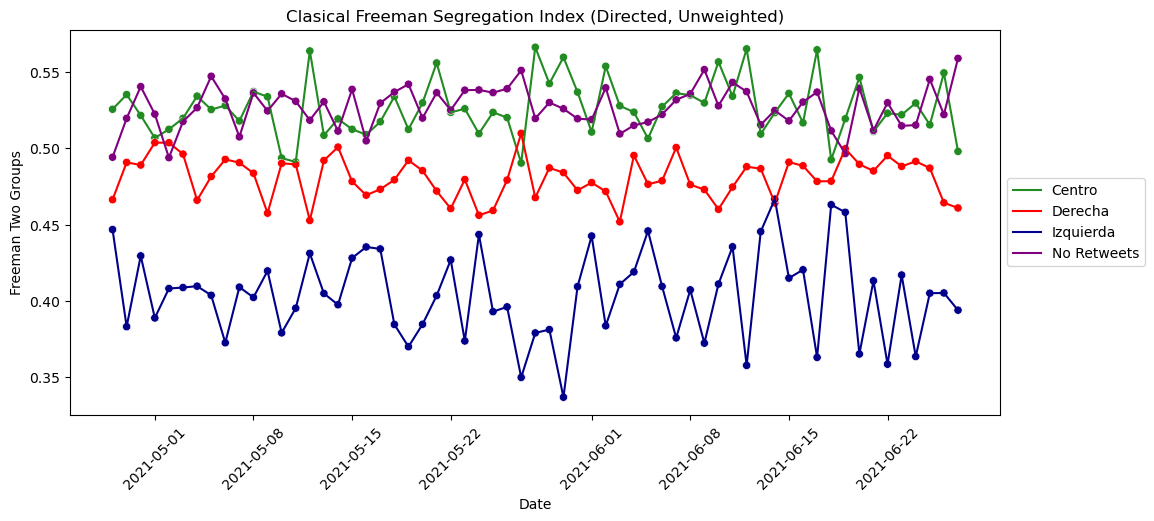

In [18]:
# Resetting index to make 'Date' a column for Seaborn's use
df = group_segregation.reset_index()
fig, ax = plt.subplots(figsize = (12,5))
# Plotting using Seaborn with different colors for each category
sns.lineplot(data = df, x = 'Date', y ='Freeman Two Groups', hue='Political Label',palette = ["forestgreen", "red","darkblue", "purple"], ax=ax)
sns.scatterplot(data = df, x = 'Date', y ='Freeman Two Groups', hue='Political Label',palette = ["forestgreen", "red","darkblue", "purple"], ax=ax, legend = False)
plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor=(1, 0.5),loc='center left')
plt.title('Clasical Freeman Segregation Index (Directed, Unweighted)')
plt.savefig("../Results/Clasical_Freeman.png")
plt.show()

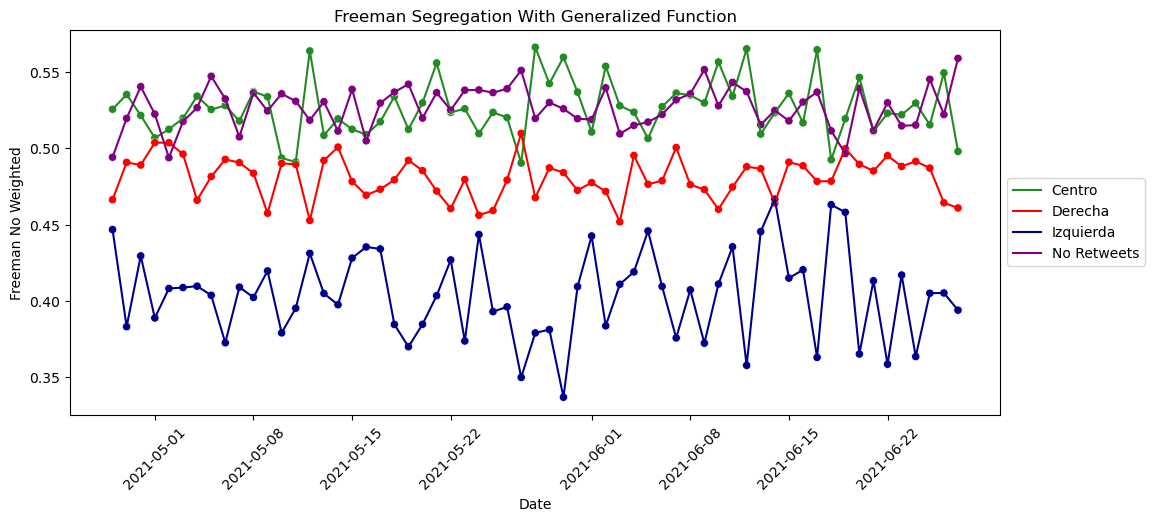

In [19]:
# Resetting index to make 'Date' a column for Seaborn's use
df = group_segregation.reset_index()
fig, ax = plt.subplots(figsize = (12,5))
# Plotting using Seaborn with different colors for each category
sns.lineplot(data = df, x = 'Date', y ='Freeman No Weighted', hue='Political Label',palette = ["forestgreen", "red","darkblue", "purple"], ax=ax)
sns.scatterplot(data = df, x = 'Date', y ='Freeman No Weighted', hue='Political Label',palette = ["forestgreen", "red","darkblue", "purple"], ax=ax, legend = False)
plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor=(1, 0.5),loc='center left')
plt.title('Freeman Segregation With Generalized Function')
plt.savefig("../Results/Clasical_Freeman_2.png")
plt.show()

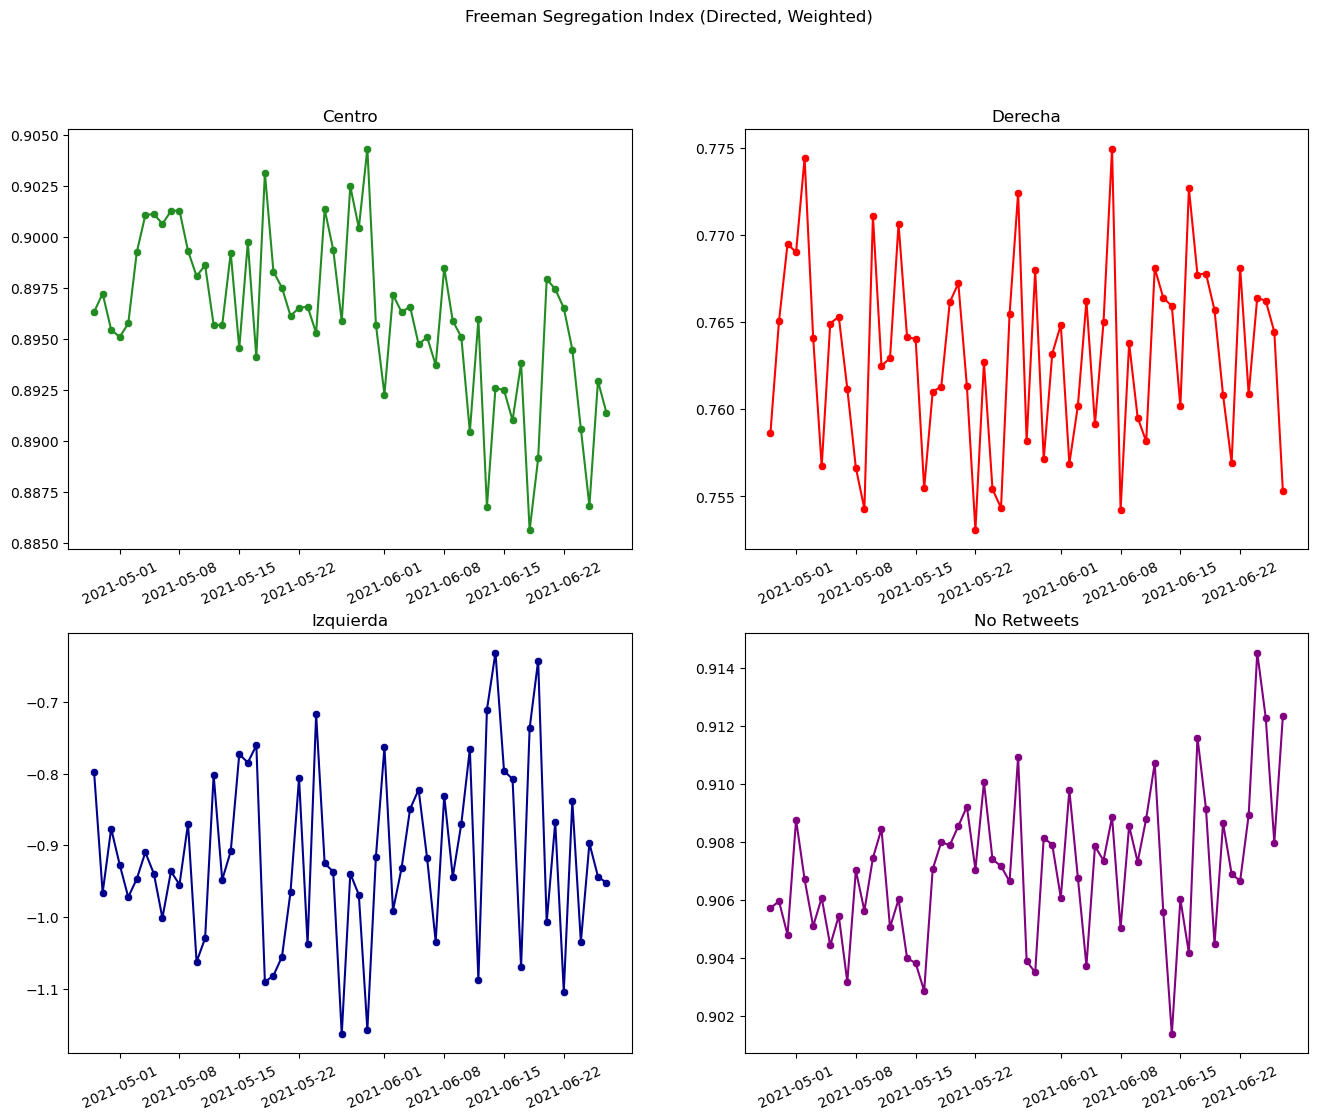

In [18]:
# Resetting index to make 'Date' a column for Seaborn's use
df = group_segregation.reset_index()
# Calculating number of axes
sq = int(np.ceil((np.sqrt(len(df['Political Label'].unique())))))
fig, axes = plt.subplots(nrows=sq, ncols=sq, figsize=(16,12))
colors = ["forestgreen", "red","darkblue", "purple"]

for i, type in enumerate(df['Political Label'].unique()):
    seg = df[df['Political Label'] == type]
    ax = axes[i // sq, i % sq]
    sns.lineplot(data = seg, x = 'Date', y ='Freeman Weighted', ax=ax, color = colors[i])
    sns.scatterplot(data = seg, x = 'Date', y ='Freeman Weighted', ax=ax, legend = False, color = colors[i])

    ax.set_title(type)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=25)
    ax.set_title(type)
    ax.set_ylabel('')
    
plt.suptitle('Freeman Segregation Index (Directed, Weighted)')
plt.savefig("../Results/Freeman_Weighted.png")
plt.show()

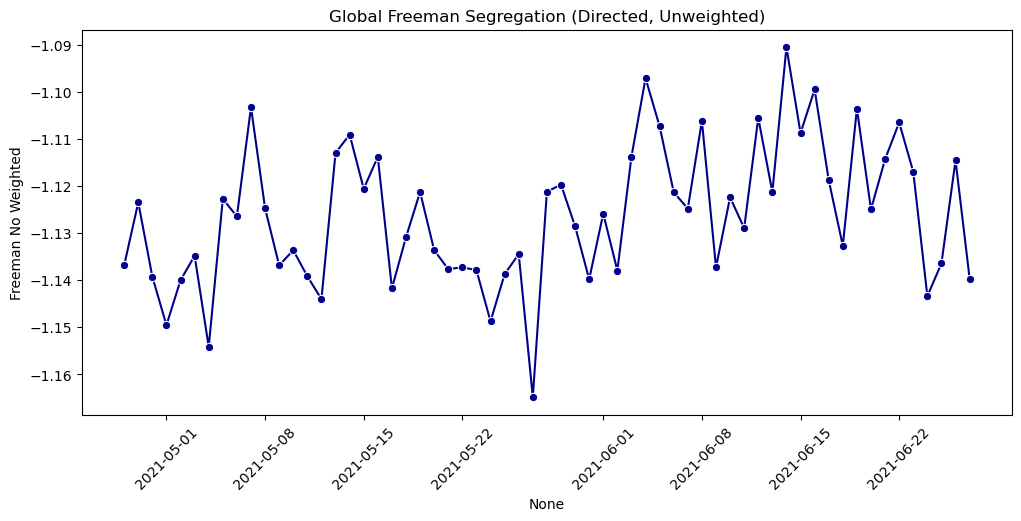

In [24]:
# Plotting using Seaborn with different colors for each category
fig, ax = plt.subplots(figsize = (12,5))
sns.lineplot(global_segregation, x = global_segregation.index, y ='Freeman No Weighted', errorbar=None, ax =ax, marker='o', color = 'darkblue')
plt.xticks(rotation=45)
plt.title('Global Freeman Segregation (Directed, Unweighted)')
plt.savefig("../Results/Global_Freeman_Unweighted.png")
plt.show()

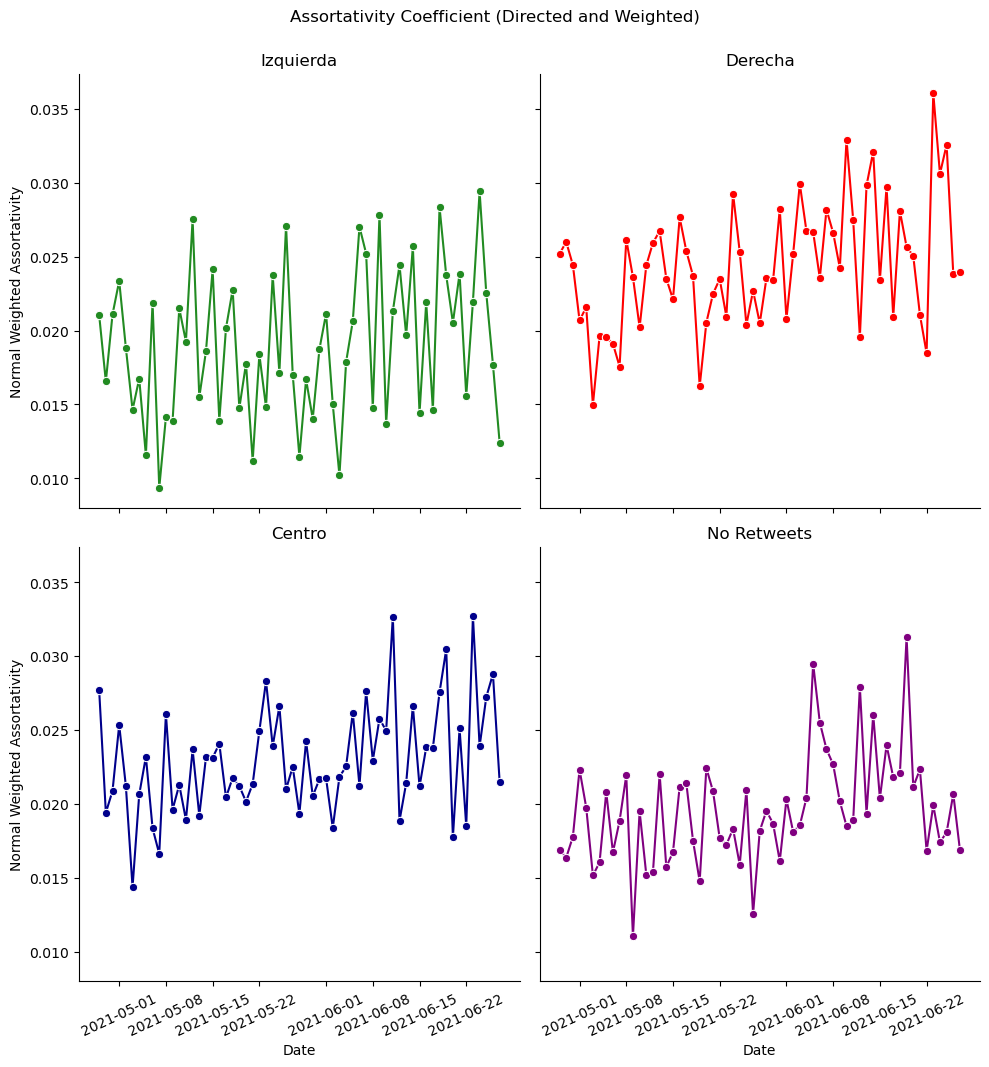

In [16]:
# Resetting index to make 'Date' a column for Seaborn's use
df = group_segregation.reset_index()

plot = sns.relplot(data = df, kind = 'line', marker='o',
            x = 'Date', y ='Normal Weighted Assortativity',
            col='Political Label', hue='Political Label', col_wrap = 2,
            palette = ["forestgreen", "red","darkblue", "purple"], legend=False)

for ax, pol in zip(plot.axes.flatten(), categories):
    ax.set_xlabel('Date')
    ax.set_title(pol)
    ax.tick_params(axis='x', rotation=25)

title_font = {'size': 40, 'weight': 'bold'}
plot.fig.suptitle("Assortativity Coefficient (Directed and Weighted)", y=1.03, fontdict=title_font)
plt.savefig("../Results/Assortativity_Weighted.png")
plt.show()

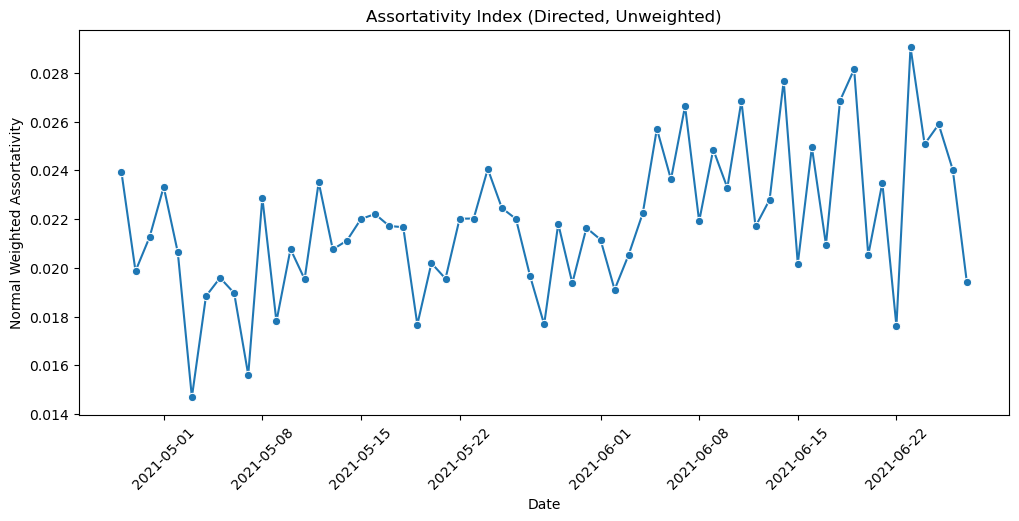

In [92]:
# Plotting using Seaborn with different colors for each category
fig, ax = plt.subplots(figsize = (12,5))
sns.lineplot(global_segregation, x = global_segregation.index, y ='Normal Weighted Assortativity', errorbar=None, ax =ax, marker='o')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Assortativity Index (Directed, Unweighted)')
plt.savefig("../Results/Assortativity_Unweighted.png")
plt.show()

In [30]:
def study_event_df(event:str, seg_index:str):
    # Study Event DataFrame (Like the group segregation but empty)
    study_events = group_segregation.copy()[[]].sort_index()
    
    # Get fixed values
    event_seg = group_segregation.loc[event, seg_index]
    event_seg = event_seg.to_dict()
    event_date = datetime.strptime(event, '%Y-%m-%d')
    
    # Get Days (X axis)
    study_events[f"days_from_{event}"] = group_segregation.index.get_level_values('Date') - event_date
    study_events[f"days_from_{event}"] = study_events[f"days_from_{event}"].dt.days
    
    # Get Segregation (Y axis)
    study_events['Segregation Deviation %'] = group_segregation.index.get_level_values('Political Label').map(event_seg)
    study_events['Segregation Deviation %'] = (group_segregation[seg_index] - study_events['Segregation Deviation %']) / study_events['Segregation Deviation %'] 
    
    # Prepare df
    study_events.reset_index(inplace=True)
    study_events.drop(columns='Date', inplace=True)

    return study_events, event

study_event_df('2021-05-12', 'Freeman Two Groups')[0]

,Political Label,days_from_2021-05-12,Segregation Deviation %
0,Centro,-14,-0.067758
1,Derecha,-14,0.030092
2,Izquierda,-14,0.036125
3,No Retweets,-14,-0.046820
4,Centro,-13,-0.050676
...,...,...,...
239,No Retweets,45,0.007073
240,Centro,46,-0.116787
241,Derecha,46,0.018080
242,Izquierda,46,-0.086357


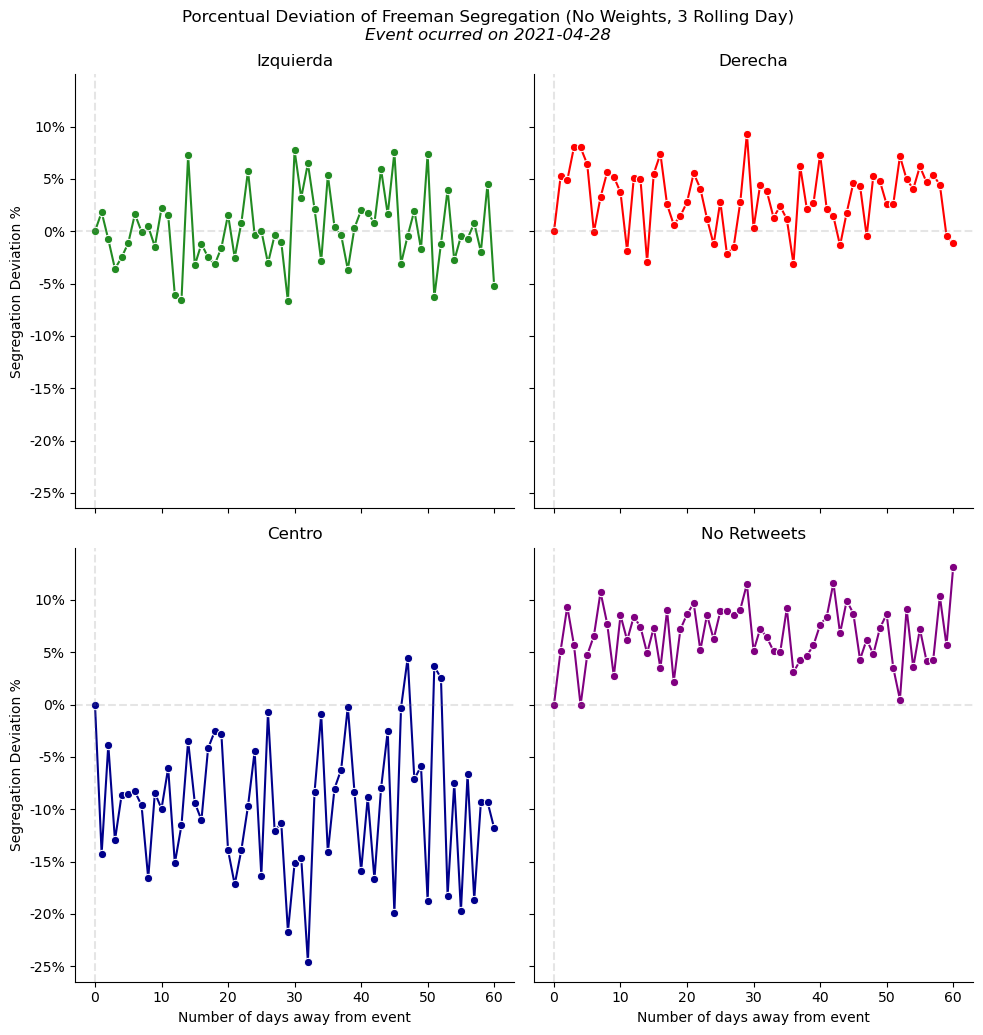

In [29]:
date = '2021-04-28'
study_events, starting_date = study_event_df(date, 'Freeman Two Groups')

# Plotting using Seaborn with different colors for each category
plot = sns.relplot(data = study_events, kind = 'line', marker='o',
            x = f'days_from_{starting_date}', y ='Segregation Deviation %',
            col='Political Label', hue='Political Label', col_wrap = 2,
            palette = ["forestgreen", "red","darkblue", "purple"], legend=False)

percentage_formatter = FuncFormatter(lambda x, pos: f'{x*100:.0f}%')

for ax, pol in zip(plot.axes.flatten(), categories):
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.2)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.2)
    ax.set_xlabel('Number of days away from event')
    ax.set_title(pol)
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

title_font = {'size': 40, 'weight': 'bold'}
plot.fig.suptitle("Porcentual Deviation of Freeman Segregation (No Weights, 3 Rolling Day)", y=1.03, fontdict=title_font)
subtitle_font = {'size': 12, 'weight': 'normal', 'style': 'italic'}
plot.fig.text(0.5, 1, f"Event ocurred on {starting_date}", ha='center', fontdict=subtitle_font)
plt.savefig(f"../Results/Event_Study_Freeman_{starting_date}.png")
plt.show()

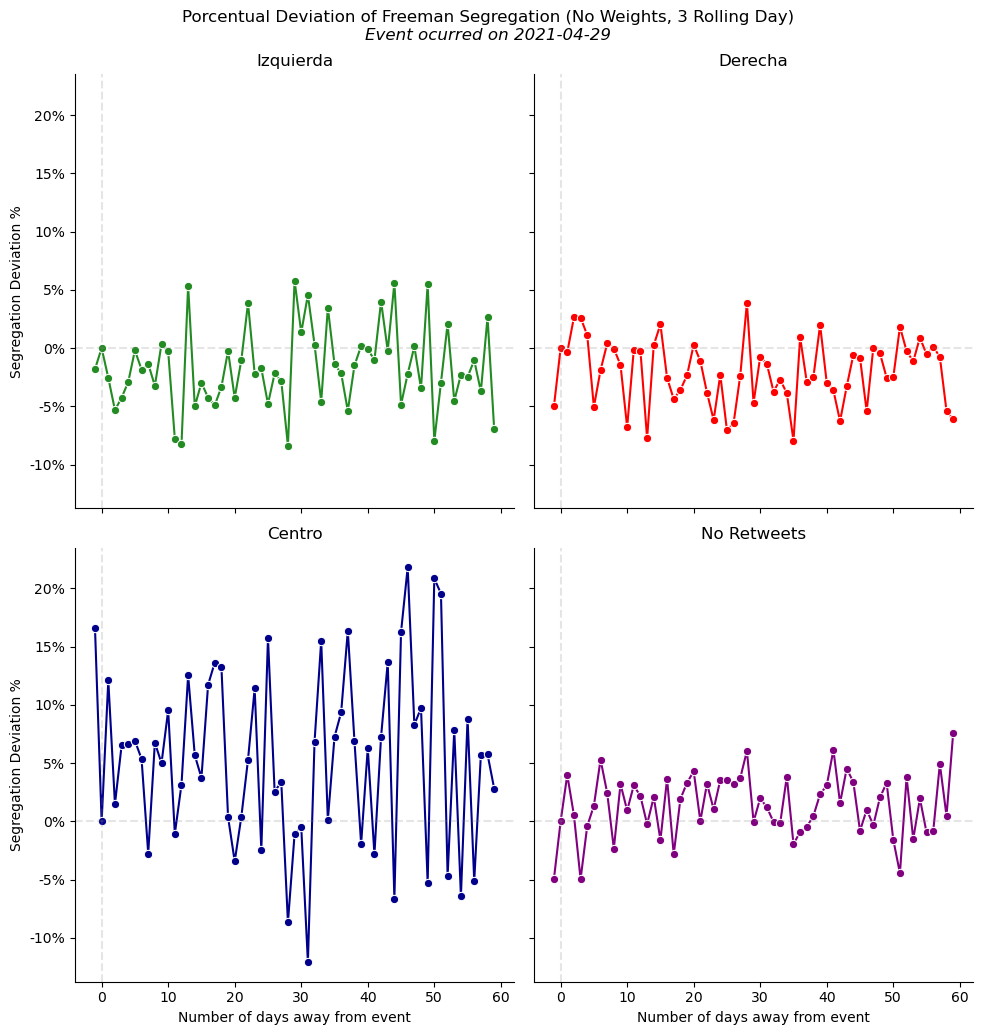

In [32]:
date = '2021-04-29'
study_events, starting_date = study_event_df(date, 'Freeman Two Groups')

study_events, starting_date = study_event_df(date, 'Freeman Two Groups')

# Plotting using Seaborn with different colors for each category
plot = sns.relplot(data = study_events, kind = 'line', marker='o',
            x = f'days_from_{starting_date}', y ='Segregation Deviation %',
            col='Political Label', hue='Political Label', col_wrap = 2,
            palette = ["forestgreen", "red","darkblue", "purple"], legend=False)

percentage_formatter = FuncFormatter(lambda x, pos: f'{x*100:.0f}%')

for ax, pol in zip(plot.axes.flatten(), categories):
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.2)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.2)
    ax.set_xlabel('Number of days away from event')
    ax.set_title(pol)
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

title_font = {'size': 40, 'weight': 'bold'}
plot.fig.suptitle("Porcentual Deviation of Freeman Segregation (No Weights, 3 Rolling Day)", y=1.03, fontdict=title_font)
subtitle_font = {'size': 12, 'weight': 'normal', 'style': 'italic'}
plot.fig.text(0.5, 1, f"Event ocurred on {starting_date}", ha='center', fontdict=subtitle_font)
plt.savefig(f"../Results/Event_Study_Freeman_{starting_date}.png")
plt.show()

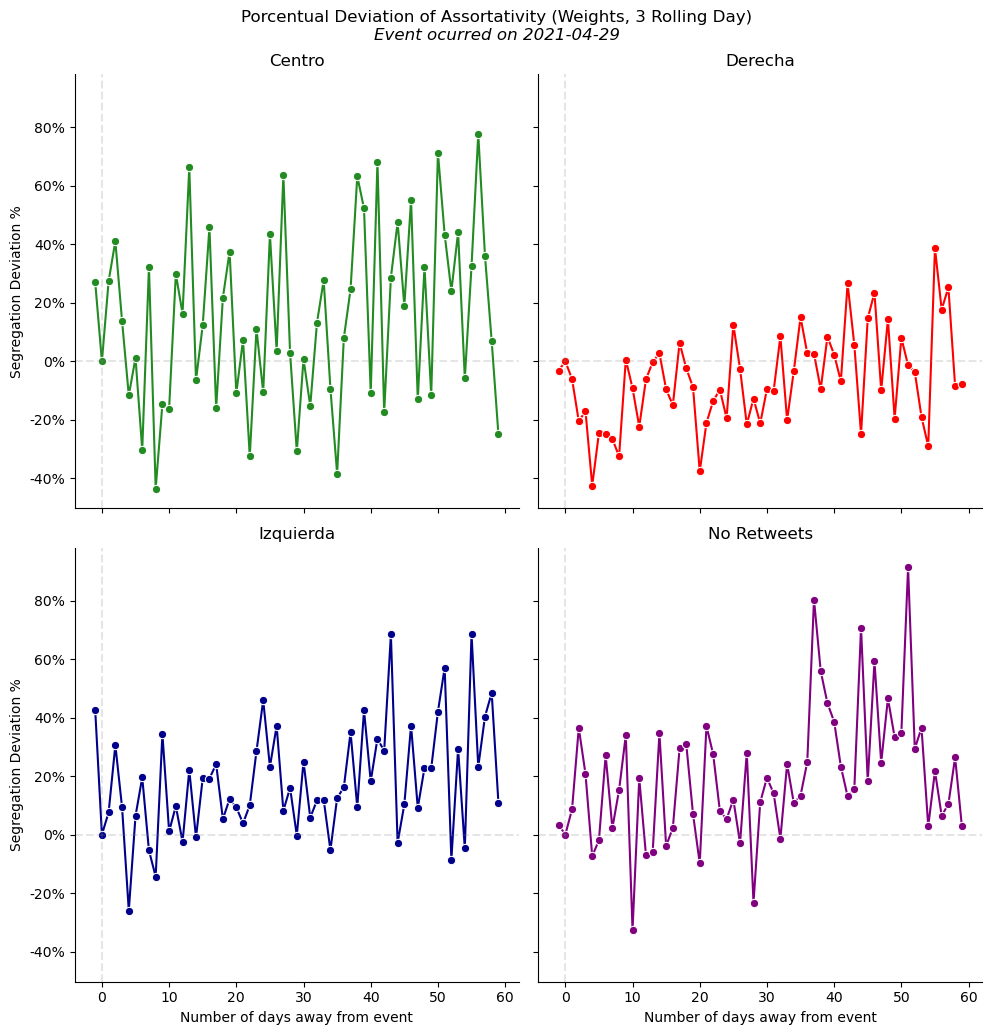

In [424]:
date = '2021-05-02'
study_events, starting_date = study_event_df(date, 'Weighted Assortativity')

# Plotting using Seaborn with different colors for each category
plot = sns.relplot(data = study_events, kind = 'line', marker='o',
            x = f'days_from_{starting_date}', y ='Segregation Deviation %',
            col='Political Label', hue='Political Label', col_wrap = 2,
            palette = ["forestgreen", "red","darkblue", "purple"], legend=False)

percentage_formatter = FuncFormatter(lambda x, pos: f'{x*100:.0f}%')

for ax, pol in zip(plot.axes.flatten(), categories):
    ax.axvline(x=0, color='gray', linestyle='--', alpha=0.2)
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.2)
    ax.set_xlabel('Number of days away from event')
    ax.set_title(pol)
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

title_font = {'size': 40, 'weight': 'bold'}
plot.fig.suptitle("Porcentual Deviation of Assortativity (Weights, 3 Rolling Day)", y=1.03, fontdict=title_font)
subtitle_font = {'size': 12, 'weight': 'normal', 'style': 'italic'}
plot.fig.text(0.5, 1, f"Event ocurred on {starting_date}", ha='center', fontdict=subtitle_font)
plt.savefig(f"../Results/Event_Study_Assortativty_W_{starting_date}.png")
plt.show()

In [5]:
g = gt.load_graph('/mnt/disk2/Data/3_Day_Graphs/starting_2021-04-29.graphml')
print(g)
filter = g.new_vp('bool')
filter.a = False

for v in g.vertices():
    if g.vp['Political Label'][v] == 'Izquierda' or g.vp['Political Label'][v] == 'Derecha':
        filter[v] = True
        
filtered_graph = gt.GraphView(g, vfilt=filter)
filtered_graph

<Graph object, directed, with 30645 vertices and 529751 edges, 10 internal vertex properties, 2 internal edge properties, 2 internal graph properties, at 0x7fe1b8b8b890>


<GraphView object, directed, with 24671 vertices and 293579 edges, 10 internal vertex properties, 2 internal edge properties, 2 internal graph properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7fe1d943e0d0, at 0x7fe1b8b58ed0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7fe1d943e0d0, at 0x7fe1b8b63c50>, False), at 0x7fe1d943e0d0>

In [32]:
vertex_dict = [(v, filtered_graph.vp['Political Label'][v]) for v in filtered_graph.vertices()]